In [7]:
from __future__ import division
import numpy.random as r
import numpy as np
import seaborn as sns
sns.set(style="white", context="talk")
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

**Now What?**

In the last section, we learned about the overall philosophical basis of Bayesian statistics and we talked through a couple examples of coducting posterior inference with conjugate priors. As you might guess, there's a limit to the kinds of model for which we can come up with a simple closed form expression for the posterior distribution. In order to move further, we're next going to learn about computational methods (collectively known as Markov chain Monte Carlo) that allow us to approximate a posterior distribution, no matter how complex. Like some of the methods we've discussed so far, including Monte Carlo and Bootstrapping, MCMC methods will take advantage of random sampling processes in order to estimate some distribution. We'll extend our Fantasy Football model and in so doing we will have to encouter our first MCMC method, called Gibbs sampling. Then we consider models for which Gibbs sampling is inadequate and we will then learn about a very general method called the Metropolis-Hastings algorithm. Both of these methods are wide used in statistics and machine learning and enable use to devise and benefit from extremely complex statistical models.  

** Markov Chain Monte Carlo **

The family of methods we're going to discuss for the remainder of this section are known as Markov chain Monte Carlo (MCMC) methods, and I first want to describe the goal and concept at a very high level. Then, we will discuss (in grueling detail), two mainstays of MCMC: Gibbs sampling and Metropolis-Hastings. We'll implement these methods from scratch, just to get a good sense of how they work. Finally, we'll take advantge of some useful Python libraries that implement a third kind of MCMC called Hamiltonian Monte Carlo, but we won't go into depth on that method. 

Recall that in Bayesian inference, our goal is to get a good understanding of the posterior distribution. In simple cases, we could come up with a closed-form expression for the posterior, and from that, we had everything we might ever want to know. In many other cases, we don't have a simple expression for the posterior. We might decide upon the likelihood and the prior, but they don't combine in an obvious way. For any particular value of the parameters, say $\theta^*$, we could easily compute $p(\theta = \theta^*|y_N)\propto p(y_N|\theta^*)p(\theta)$, this is a simple multuplication. But what we don't have is an understanding of the posterior over the full parameter space of $\theta$. We could compute $p(\theta = \theta^*|y_N)$ for many (or approximately all) values of $\theta^*$, but you might guess that this would require an exponentially increasing amount of effort as the numbers of parameters increases. And this is a common problem, as many models that are truly interesting and useful might have dozens, hundreds, or thousands of paramters. Instead, we're going to settle on an idea that allows us to *approximate* the true posterior.

Consider that *if* we knew the posterior, $p(\theta|y_N)$, we would probably want to summarize some of its features such as its mean (*where* is it located) and its variance (how *wide* is it). These calculations can be performed with an integral: ${\bar \theta} = \int p(\theta|y_N)d\theta $. And again, if we had a nice expression for $p(\theta|y_N)$, we could probably figure out that integral pretty easily. But we don't have that. But consider this: what if we instead had a bunch of random samples of values of $\theta$ drawn from $p(\theta|y_N)$. Let's call these $\theta_i \sim p(\theta|y_N)$. Then with enough random samples, we could approximate that integral with the *average* value of $\theta_i$: $\int p(\theta|y_N)d\theta \approx \frac{1}{n}\sum_{i=1}^n \theta_i \textrm{ where } \theta_i \sim p(\theta|y_N)$. I've mentioned this idea before, and it's called Monte Carlo Integration and the task of approximating difficult integrals is the reason that the physics community invented Monte Carlo methods in the first place. But the reason I bring this up is to demonstrate a more basic idea that we'll use. Even if we don't know much about $p(\theta|y_N)$, we can get a useful appproximation of its structure and properties if we can *draw random samples* from the posterior. 

This begs the important question - if we don't know much about $p(\theta|y_N)$, how could we possibly draw random samples from it? The fundamental premise of MCMC methods is that we can, by some cleverness and magic, devise a *Markov chain* whose limiting distribution is $p(\theta|y_N)$. Then, by simply simulating this Markov chain for some time, we have generated random samples from the posterior. There are several methods for constructing such a Markov chain and we'll cover two in detail: Gibbs sampling and Metropolis-Hastings.

**Markov Chains**

In case we've already jumped into unfamiliar territory, let's take a breather here and recall a little bit about Markov chains. Here's a grossly-paraphrased and inextact definition that will serve us well for now. A Markov chain is a random process whose future depends in some way on its past. All we'll be concerned with are called first-order Markov chains, so we can constrain our definition to say that a (first-order) Markov chain is a random process whose future depends only on the present. That is, given the present, the past doesn't matter for predicting the future. Said differently, given where a Markov chain is *now*, that's all I need to know to make a guess about what will happen next, and it doesn't matter how it got to now. 

To get a concrete sense of a first-order Markov chain, let's talk about the random walk. The physicists call this the Drunkard's Walk, so let's go with that analogy. Imagine we have a young Physicist who exits a bar after a long night of drinking. His inebriation makes his walk home uncertain, and quite random. So imagine at time $0$ he is at location $0$ (the door to the bar). At time $1$, he talks a step left or right with probability $1/2$. Then, from wherever he is at time $1$ (let's use the notation that his location is $x_1$ at time $t_1$), he takes another step left or right for $t_2$. This process continues indefinitely, and hopefully he makes it home eventually. 

Here's an example path he might take, where we'll represent a step to the left at $+1$ and a step to the right at $-1$.

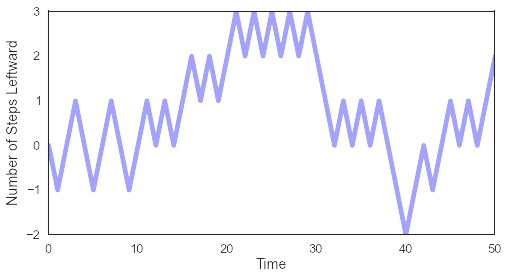

In [14]:
path = np.cumsum( np.append(0, r.choice([+1,-1],50)))
f, ax  = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
x=range(len(path))
ax.plot(x,path,'b-', lw=5, alpha=0.6)
ax.set_ylabel("Number of Steps Leftward")
ax.set_xlabel("Time")

Note that at each time, if we want to predict where he's going to go next, we only need to know where he is now. For example, if he's at location $x_8$ at time $t_8$, then we know that at time $t_9$, the probabilty distribution over his possible locations will be $x_8 + 1$ with probability $\frac{1}{2}$ and $x_8 - 1$ with probability $\frac{1}{2}$. This is a defining feature of a Markov chain. We don't care *how* he got to location $x_8$ at time $t_8$, we only need to know $x_8$.

The path we just looked at it is just one path out of very many possible paths. Let's re-simulate this random walk many times, and get a sense of all possible outcomes.

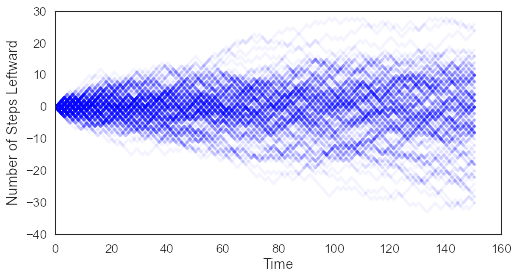

In [20]:
path = np.cumsum( np.append(0, r.choice([+1,-1],150)))
f, ax  = plt.subplots(1, 1, figsize=(8, 4), sharex=True)
x=range(len(path))
ax.plot(x,path,'b-', lw=3, alpha=0.2)
ax.set_ylabel("Number of Steps Leftward")
ax.set_xlabel("Time")

for i in range(100):
    path = np.cumsum( np.append(0, r.choice([+1,-1],150)))
    ax.plot(x,path,'b-', lw=3, alpha=0.2)

Let's notice a couple things. First, the higest density of these paths is around the horizontal $x_t=0$ line. That is, on average, he shouldn't really be able to travel anywhere, he would just bounce around back and forth around the zero line. There are trajectories that have him going out to very high or low values, but in general, they are more improbable. Second, notice the *spread* of where he might be as a function of how many steps he has taken. For example, after 20 steps, he is with high probability still within several steps of the starting location. However, after 150 steps, his average location is still $0$, but there's a higher chance that his is farther away from the starting point. At each time point, think of taking a vertical slice through this plot, and looking at the possible locations that he *could* have visited. Early on, that distribution is narrow. But later on, after walking many steps, that distribution *spreads* out. 

As we take Time out to infinity, we can ask What does the distribution look like of where the Markov chain might be. This is called the *limiting distribution* of a Markov chain. In the random walk example, you might have a sense that spread of the paths gets wider and wider for longer times. For the random walk, the limiting distribution gets infinitely wide. (surprise, the limiting distribution of the random walk approaches a Normal distribution with mean of $0$ and variance proportional to the numner of steps taken, you get that little factoid for free). So we say that the random walk Markov chain doesn't have a fixed and finite limiting distribution. 

However, other kinds of Markov chains will have a fixed limiting distribution, and the idea of MCMC is to design a Markov chain such that its limiting distribution is exactly equal to the posterior distribution that we're interested in. Then, by simply simulating such a Markov chain for a while, we get random samples from the posterior. We're next going to tackle our first method for constructing such a Markov chain: the Gibbs sampler. 

** A Harder Problem **

Let's return to our Fantasy Football idea and address a somewhere harder problem (though one that perhaps not actually useful for Fantasy Football but it's a good example). For each player, we observe how many points they've earned us in each game. And some players certainly earn more than others and really, certain types of players tend to earn us more points than others. For example, quarterbacks generally tend to earn more points than tight ends and certainly than kickers. So let's imagine something that is impractical for the sake of fantasy football, but will serve as a useful example problem to work through. Let's imagine we have a bunch of observations of points, but have lost track of who the players are and what the positions are. We generally think that kickers all probably score a similar number of points to each and that quarterbacks all probably score a similar number of points. What we want to do is to separate all the observations into different groups and estimate the properties of each group. We don't know the groups in advanced (well, pretend we don't) so we have no "ground truth" and this problem is an example of *unsupervised clustering*. Again, in the fantasy football context, this problem is a little silly, but unsupervised clustering is a very general idea that is at the heart of many useful and complex methods such as Latent Dirichlet Allocation and Hidden Markov Models. This simple unsupervised clustering problem will allow us to introduce the components at the base of our MCMC methods, which will be common in more complex methods.

Let's grab some fake data to mimic this idea.

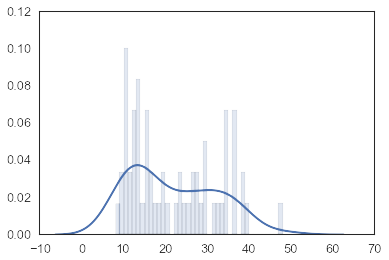

In [155]:

import numpy as np
import numpy.random as r
import seaborn as sns
%matplotlib inline

someFakeData =np.append( r.poisson(30,size=30)\
                        ,r.poisson(13,size=30))
sns.distplot(someFakeData,bins=40)

When we take a look at the data, we get a sense that it could be separated into multiple groups. That is, it might be the case that this data is a mixture of two different Poisson processes with two different $\lambda$ values. This is what we're going to try to solve with unsupervised clustering. We want to put all the data points into two groups, where the points within each group are similar, but the two groups themselves are dissimilar. 

Given this idea, we can state our premise about the likelihood. It is helpful to think through the supposed "data generating process" or DGP. Our mixture/clustering idea implies the following DGP. Each observation $y_i$ was a random draw from one of two distinct Poisson distributions. That is, in order to generate an observation, we first flip a coin (which has some bias $w$), and then depending on the outcome of that coin toss, we consult the Poisson distribution with parameter either $\lambda_1$ or $\lambda_2$, and then we take a random sample from that Poisson, and that's what $y_i$ is. The reason for the coin's biad $w$ is that we don't know *how many* data points belong to each distribution, they needn't neccessarily be equally prevalent. 

Stating all of that more formally, our likelihood is

$
p(y_i|\lambda_1,\lambda_2,w) = w \textrm{Poiss}(\lambda_1) + (1-w)\textrm{Poiss}(\lambda_1) \\
= w \frac{\lambda_1 ^ {y_i}}{y_i !}e^{-\lambda_1} + (1-w) \frac{\lambda_2 ^ {y_i}}{y_i !}e^{-\lambda_2} 
$

Or similarly, we can express that $y_i$ is drawn from this mixture

$
y_i \sim w \frac{\lambda_1 ^ {y_i}}{y_i !}e^{-\lambda_1} + (1-w) \frac{\lambda_2 ^ {y_i}}{y_i !}e^{-\lambda_2} 
$

And for each observation, we assume that they are independent of one another, so the total likelihood is just the product.

$
p(y_N|\lambda_1,\lambda_2,w) =  \prod_{i=1}^N w \frac{\lambda_1 ^ {y_i}}{y_i !}e^{-\lambda_1} + (1-w) \frac{\lambda_2 ^ {y_i}}{y_i !}e^{-\lambda_2} 
$


We have three parameters of interest ($\lambda_1,\lambda_2,w$), so the posterior is

$p(\lambda_1,\lambda_2,w | y_N) \propto p(y_N|\lambda_1,\lambda_2,w)p(\lambda_1,\lambda_2,w) \\
= \left( \prod_{i=1}^N w \frac{\lambda_1 ^ {y_i}}{y_i !}e^{-\lambda_1} + (1-w) \frac{\lambda_2 ^ {y_i}}{y_i !}e^{-\lambda_2}\right) p(\lambda_1,\lambda_2,w)
$

The problem here is that because of the mixture/clustering nature of the likelihood, we're not going to be able to come up with a simple conjugate prior. The parameters ($\lambda_1,\lambda_2,w$) would define a posterior that lives in the product space ${\mathbb R}^1x{\mathbb R}^1x{\mathbb U}_0^1$, and I can't really think of what kind of distribution would live on that space. 

We're going to first employ a little trick called *data augmentation* (a misnomer, since we'll augment the parameters and not the data). This idea will (seemingly) make our problem much more challening, but in the end will allow us to use MCMC very simply. We're going to add new parameters to our model. In particular, we're doing to create a *latent indicator* parameter $s_i$ for every data points $y_i$. This latent indicator keeps track of *which* of the Poisson mixtures the data point $y_i$ was likely drawn from. So in our two mixture example, $s \in \{1,2\}$. Our posterior now has many parameters,

$
p(\lambda_1,\lambda_2,w,s_1,s_2,...,s_N|y_N)
$
so it seems like our problem just got harder for no clear reason. It might also seen odd that we *can* just add parameters to our model willy nilly. Well, consider that as we *marginalize* out the new variables, we get back to our first simpler model. That is

$
\int p(\lambda_1,\lambda_2,w,s_1,s_2,...,s_N|y_N) ds_1, ds_2,...,ds_N =  p(\lambda_1,\lambda_2,w|y_N)
$

And as you might guess, that integral is going to be done *approximately* with Monte Carlo integration, in the Gibbs sampler we're creating, so even though we make the problem worse by adding more parameters, we get back to our desired posterior, and as we'll explore next, this posterior sets up a useful Gibbs sampler. 

** Gibbs Sampling **

Here's some very general facts about conditional and joint probabilities of two random variables $A$ and $B$.

$
p(A|B) = \frac{p(A,B)}{p(B)}, \\
p(A,B) = p(B)p(A|B), \\
p(A,B) \propto p(A|B)
$

Similarly, I could have caluclated these conditionals with respect to the other random variable,

$
p(B|A) = \frac{p(A,B)}{p(A)}, \\
p(A,B) = p(A)p(B|A), \\
p(A,B) \propto p(B|A)
$

From combining both of these we see that the joint $p(A,B)$ is proporitional to both of its conditionals $p(A|B)$ and $p(B|A)$. This fact holds true for higher dimensional joint probabilities. Here's why this is useful. Suppose some joint probability distribution is hard to say anything about (such as $p(\lambda_1, \lambda_2,w|y_N)$). *But*, any particular one-dimensional conditional is somewhat easier to get a handle on (such as $p(\lambda_1| \lambda_2=\lambda^*,w=w^*,y_N)$ ). Well since the joint is conditional to the marginal, a random sample from the conditional $p(\lambda_1| \lambda_2=\lambda^*,w=w^*,y_N)$ is linearly proporitional to, and thus a valid random sample from, the full joint distribution, $p(\lambda_1| \lambda_2=\lambda^*,w=w^*,y_N)$. This insight is the key to Gibbs sampling. The full posterior is high-dimensional, complex, and scary. But each univariate conditional is simple. So the stragegy is to cyclically sample from the univariate conditionals, thus getting better and better approximations to the true posterior. We'll get to a concrete example with our Poisson mixture, but for generality, let's talk through a Gibbs sampler with generic random variables $A$ and $B$.

Our goal is to draw random samples from $p(A,B)$, but we can't. We can, however, draw random samples from $p(A|B=b)$ or from $p(B|A=a)$. We initalize random variables $a_0$ and $b_0$. We draw a new sample $a_1$ from the distribution $p(A|B=b_0)$. We then draw a new sample $b_1$ from the distribution $p(B|A=a_1)$. We then come back to parameter $A$ and draw $a_2$ from $p(A|B=b_1)$, and so on. That's it, that's Gibbs sampling. This iterative procedure, as simple as it is, defines a particaular process: a Markov chain. Notice that each sample $a_t$ is drawn conditioned on only $b_t$ (which depended upon $a_{t-1}$). Therefore this process is Markovian, and that values of $a_t$ and $b_t$ throughout this prodecure form a two-dimensional Markov chain that walks around the parameter space. Most importantly, this Markov chain, as we've defined it, has a precise limiting distribtion. I'll skip the proofs (which are rather involved), but the limiting distribution of this Markov chain is linearly proportional to the full joint distribution $p(A,B)$. Recall that this was the goal of MCMC - even though we don't have a simple form for $p(A,B)$, we've constructed a Markov chain process which approaches $p(A,B)$, so by simulating this process, we generate samples from $p(A,B)$. So let's return to our example and put this to work.

Recall that our full posterior is this messy thing

$p(\lambda_1,\lambda_2,w,s_1,...,s_N|y_N)$. Let's first notice that we could break that up into a few distinct *types* of conditional distributions.

$
p(\lambda_j|...), \\ 
p(w| ...), \\
p(s_i|...)
$

For brevity, I'm now using the notation $p(\lambda_j|...)$ to denote that the conditioning is with respect to every other variable in the model. To get started, let's consider what the $s_i$ indicator variables do for us. I said that by making the model more complicated by adding them in, we'll gain some benefit later. Well, each $s_i$ serves to "label" each data point as belonging to one of two groups. Let's call $A_j$ the set of all $y_i$ where $s_i=j$. So for example $A_1$ is the set of all datapoints where $s_i$ is 1: the set of all datapoints that we might think belong together in cluster number 1. As we'll see, this $A_j$ will be fairly useful, for example the magnitude $|A_j|$ tells us how many data points are in each cluster, and it also provides us with a mechanism to partition the data points into the two clusters. Now let's start thinking through the univariate conditional posteriors.

Let's first consider the Poisson rate parameters and their conditional posterior $p(\lambda_j|...)$. Well we already talked about a good conjugate prior for this *kind* of random variable - the Poisson-Gamma, but how can we apply that to $p(\lambda_j|...)$? Well, because of the latent indicators $s_i$, and because we're intertested in $p(\lambda_j)$ conditioned on *every other* variable in the model, we can reuse that simple conjugate prior. That is, given the current values of the $s_i$, we can figure out the partitions $A_j$. Then, from the corresponding partition, we make use of the simple Poisson-Gamma distribution.

$
p(\lambda_j|...)\propto \prod_{i \in A_j} p(y_i|\lambda_j)p(\lambda_j)\\
= \textrm{Gamma}(A,B)\\
\textrm{ where } \\
A= a + \sum_{i \in A_j} y_i ,\\
B = b + |A_j|
$

Take a sec to walk through that idea a couple times if you need, because it's central to why Gibbs sampling is useful. Remember that the thing we're interested in,$p(\lambda_1,\lambda_2,w,s_1,...,s_N|y_N)$, is too unwieldy. But, we can tackle a tiny piece of it, $p(\lambda_j|...)$, and conditioned on everything else, the posterior over $\lambda_j$ is simple and familiar. We can figure out $A_j$ from the current values of the $s_i$, and we can easily calcualte $A$ and $B$ from $A_j$, and we can draw random samples from a Gamma distribution, so we have what we need to draw a random value of $\lambda_j$, which gives a sample from the full posterior distribution.

Now that we know one of the components of our Gibbs sampler, $p(\lambda_j|...)$, let's move on to another. The next simplest one to think about will be the posterior over the labels $s_i$. The posterior $p(s_i|...)$ asks the question Given the current estimate of all the other model parameters, what's my best guess at the right "label" for datapoint $i$. Let's approach this concretely with our two-component mixture model. We know we are consider two distinct Poisson distributions parameterized by $\lambda_1$ and $\lambda_2$. We know the form of the likelihood of any particular datapoint, $p(y_i|\lambda_j,...)$, which would just be the Poisson likelihood with parameter $\lambda_j$. So for a data point $y_i$, we need to ask which is more likely, $p(y_i|\lambda_1,...)$ or $p(y_i|\lambda_2)$. That is, our estimated values of $\lambda_1$ and $\lambda_2$ are probably different (in any given iteration of Gibbs sampling), so we just calculate the likelihood of $y_i$ under each. Let's use the notation $L_{i,j}$ to denote the likelihood of datapoint $i$ under mixture component j. So $L_{i,1} = p(y_i|\lambda_1)$ and $L_{i,2} = p(y_i|\lambda_2)$. With these absolulte likelihoods, we can comptute the *relative* likelihoods, and this gets us to our posterior probabilities. That is, 

$
p(s_i=1|...) = \frac{L_{i,1}}{L_{i,1} + L_{i,2}} \\
= \frac{p(y_i|\lambda_1)}{p(y_i|\lambda_1) + p(y_i|\lambda_2)}
$

and

$
p(s_i=2|...) = \frac{L_{i,2}}{L_{i,1} + L_{i,2}} \\
= \frac{p(y_i|\lambda_2)}{p(y_i|\lambda_1) + p(y_i|\lambda_2)}.
$

We now have two probabilities, and because this is MCMC (and not purely and optimization method), we want to *sample* $s_i$ instead of just taking the highest one. Since we only have two choices here and since $p(s_i=1|...) + p(s_i=2|...)=1$, we can focus on just one of them, say $p(s_i=1|...)$, and just use this to flip a biased coin. Such a coin flipping process is often called the Bernoulli distribution, so we can say

$
s_i \sim \textrm{Bernoulli}(prob=p(s_i=1|...)).
$

We now have two out of three components of our Gibbs sampler:

$
\lambda_j \sim \textrm{Gamma}(A,B), \textrm{ where } A= a + \sum_{i \in A_j} y_i , B = b + |A_j|, \\
\textrm{and} \\
s_i \sim \textrm{Bernoulli}(prob=p(s_i=1|...)).
$

The last component is the weight parameter $w$, and this part is pretty easy. The weight $w$ is quantifying the proporition of each mixture component in the data. That is, perhaps 10 percent of the datapoints come from component $1$ and 90 percent come from component $2$, and we need to figure out these proportions. Luckily, we've already done all the hard work for this part. Recall the $A_j$, which is the set of all data points assigned to component $j$. Well, given the $s_i$ and the $A_j$, we can use the magnitudes $|A_j|$ to tell us the relative proportions of each component. That's going to be most of it, but we're going to smooth that out in the Bayesian way, using a conjugate prior we've already met. Remember the Beta-Binomial posterior we discussed last  section when we revisted the coin flipping game. This is exactly what we need. Since we only have two mixture components, assigning the $s_i$ is like a coin flipping process, and we already talked about using the Bernoulli distribution for that. Similarly, estimating the *bias* of that coin is analagous to estimating the weight $w$ of component number $1$. And we already know how to do a Bayesian estimate of a coin's bias - that's the Beta-Binomial. So again, our whole posterior is complicated and unwieldy, but *conditioned on all the other variables*, this part of the posterior is super simple and familiar. That is,

$
w \sim \textrm{Beta}(C,D) \\
\textrm{where } C=a + |A_1|,  D= b + |A_2|.
$

That's our whole Gibbs sampler. That gaint, messy, unmanagable posterior $p(\lambda_1,\lambda_2,w,s_1,...,s_N|y_N)$ breaks up simply into these three *types* of parts:

$
\lambda_j \sim \textrm{Gamma}(A,B),\\
s_i \sim \textrm{Bernoulli}(prob=p(s_i=1|...)), \\
w \sim \textrm{Beta}(C,D)
$

So we iterively resample each parameter, in the way just described, and after many iterations, we are successfully simluating a Markov chain whose limiting distribution approches the true posterior. Let's try it. 

(Side note - because of our two-component model, we've been able to use the Bernoulli and Beta distributions and keep things simple. The generalization of these is called the Multinomial-Dirichlet distribution and allows us to consider many components, not just two.)

In [157]:
import numpy.random as r
import numpy as np
from scipy.stats import poisson 
from scipy.stats import gamma
from scipy.stats import beta

class PoissonMixtureGibbs:
    """
    Two-component Poisson mixture model and Gibbs sampler for parameter inference. 
    """

    
    def __init__(self,data):
        self.data=data
        self.__intialize_params()
        
    def __intialize_params(self):
        self.lam_1=[2]
        self.lam_2=[5]
        self.w=[.5]
        self.S=r.choice([1,2], len(self.data))
        

    def fit(self,iterations):
        for i in range(iterations):
            self.__sample_s()
            self.__sample_lambda()
            self.__sample_w()
            
        
                    
    def __sample_s(self):
        new_S=[]
        for i in range(len(self.data)):
            datapoint = self.data[i]
            # likelihood of this datapoint from component 1
            L1 = poisson.pmf(datapoint, self.lam_1[-1])
            # likelihood of this datapoint from component 2
            L2 = poisson.pmf(datapoint, self.lam_2[-1])
            # Normalize the likelihoods
            p1 = L1/(L1+L2)
            # now sample a new label S for this datapoint
            new_S.append(r.choice([1,2], p = [p1, (1-p1)]))
        self.S=new_S
        
    def __sample_lambda(self):
        # lam1  
        A_1 = [self.data[idx]   for idx,val in enumerate(self.S) if val==1]
        draw = gamma.rvs(1 + sum(A_1), loc=0, scale= 2/ (len(A_1) * 2 + 1), size=1)[0]
        self.lam_1.append(draw)
        
        # lam2
        A_2 = [self.data[idx]   for idx,val in enumerate(self.S) if val==2]
        draw = gamma.rvs(1 + sum(A_2), loc=0, scale= 2/ (len(A_2) * 2 + 1), size=1)[0]
        self.lam_2.append(draw)
        
    def __sample_w(self):
        A_1 = [self.data[idx] for idx,val in enumerate(self.S) if val==1  ]
        self.w.append( beta.rvs(1,5,size=1)[0]  )
        
    def point_estimate(self):
        """
        Print a point estimate for each parameter
        """
        print "Estimate for Lambda 1: " + str(np.mean(self.lam_1))
        print "Estimate for Lambda 2: " + str(np.mean(self.lam_2))
        print "Estimate for w: " + str(np.mean(self.w))
        
    def intervals(self):
        """
        Print the 95% credible intervals for each parameter
        """
        
        def cred_int(s):
            s.sort()
            a = int(np.floor(.05 * len(s)))
            b = int(np.floor(.95 * len(s)))
            return (str(np.round(s[a],2)),str(np.round(s[b],2)))
        
        
        res = cred_int(model.lam_1[10:])
        print "95 percent credible interval for Lambda 1: %s to %s" %res 
        
        res = cred_int(model.lam_2[10:])
        print "95 percent credible interval for Lambda 2: %s to %s" %res 
        
        res = cred_int(model.w[10:])
        print "95 percent credible interval for W: %s to %s" %res 
        

In [158]:
someFakeData =np.append( r.poisson(30,size=60),r.poisson(5,size=20))
model = PoissonMixtureGibbs(someFakeData)
model.fit(500)

We can take a quick look at our posterior samples, and get a point estimate (just the average).

In [20]:
model.point_estimate()

Estimate for Lambda 1: 5.34240081918
Estimate for Lambda 2: 30.2798304782
Estimate for w: 0.15730198223


So we were able to accurately recover a good point estimate of our model parameters. But this is Bayesian way, we don't want just a point estimate, we want the full posterior distributions. And that's what we've sampled, so let's visualize our posterior samples.

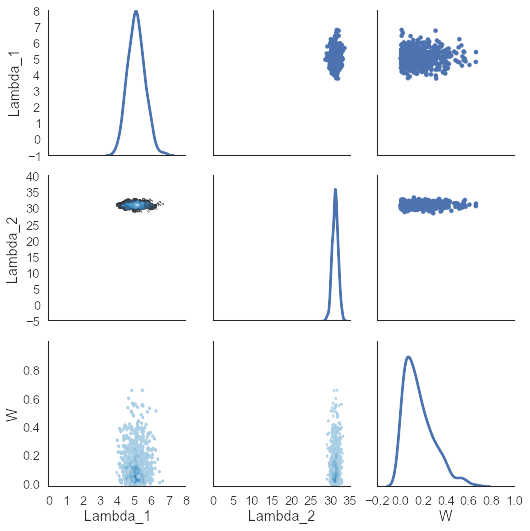

In [151]:
params = pd.DataFrame({"Lambda_1":model.lam_1[5:], "Lambda_2":model.lam_2[5:], "W":model.w[5:]})

g = sns.PairGrid(params, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

Along the diagonal of this figure, we see the (marginal) posterior distributions of each parameter. On the off-diagonal, we see visualizations of 2D joint posteriors. From this, we know with precisely quantifiable confidence that $\lambda_1$ is likely between 4 and 6 and $\lambda_2$ is likely between 29 and 35. To be more precise, we could extract a 95 percent credible interval (that's what Bayesians call it). 

In [28]:
model.intervals()

95 percent credible interval for Lambda 1: 4.58 to 6.13
95 percent credible interval for Lambda 2: 29.25 to 31.63
95 percent credible interval for W: 0.01 to 0.49


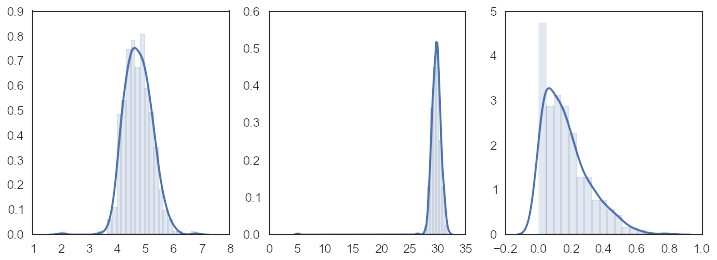

In [160]:
plt.rcParams['figure.figsize'] = (12, 4)
plt.subplot(131)
sns.distplot(model.lam_1)
plt.subplot(132)
sns.distplot(model.lam_2)
plt.subplot(133)
sns.distplot(model.w)

** Metropolis-Hastings **

With Gibbs Sampling, there's one thing we simply have to have in order for the premise to work: a simple expression for the univariate posteriors. These were the key to generating the Markov chain for the full posterior. But there are inevitable situations where we don't even have this much information. We may have a likelihood and prior in mind, but they don't combine in any simple way and we don't have a clear form for the posterior. In this situation, we'll use a much more general method called the Metropolis-Hastings algorithm. 

As a pretty general example, we're going to tackle "curve-fitting", a common task in science and engineering. In this case, we imagine that some data we observe comes from some known scientific model and is obscurred by experimental noise. We want to ue this noisy data to use this noisy data to estimate some unknown scientific parameters.

For example, let's image we're try go estimate the parameters of a noise sine curve:

In [3]:
from scipy import sin
from scipy.stats import norm

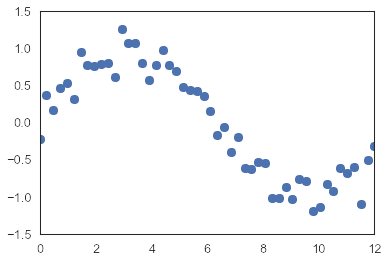

In [8]:
x = np.linspace(0,12,50)
y = sin(.5*x) + norm.rvs(size=len(x),loc=0,scale=.2)
plt.plot(x,y,'o')

In this case, we want to use the noisy data to estimate the *frequency* parameter ($\theta$) of the underlying sine curve, which here is equal to 0.5. So let's set up what we need to approach this problem in a Bayesian way. 


As should be familiar, here's Bayes' rule:

$
p(\theta|y_N) \propto p(y_N|\theta) p(\theta).
$

So what do we know about the likelihood, $p(y_N|\theta)$? Well, we've already thought through the *generative model* here: these data points are generated from a sine curve plus some Normally distributed noise, 

$
y_i \sim sin(\theta*x_i) + \textrm{N}(0,\sigma^2).
$

We could say the same thing differently to calculate the likelihood - it's a Normal likelihood centered at the location predicted by the sine curve.

$
p(y_i|\theta,\sigma) = \textrm{N}(y_i; f(x_i), \sigma^2), \textrm{where } f(x_i) = sin(\theta*x_i)
$

That's simple enough, how about the prior? We can choose whatever prior we like, so let's pick a familiar one. Let's use an exponential prior for $\theta$ and a different exponential prior for $\sigma$. Thus, we might write the posterior as:

$
p(\theta,\sigma|y_N) \propto \prod_i \textrm{N}(y_i; f(x_i), \sigma^2) p(\theta) p(\sigma).
$

Bad news here is that our prior and likelihood won't combine nicely. And it won't be easy to just pick another kind of prior. The problem is that the likelihood, even though it's a simple Normal distribution, is related to our model parameter $\theta$ through that complicated sine function. We simply won't be able to come up with a simple closed-form for anything here. 


But for any single value of $\theta$ and $\sigma$, we can calculate $p(y_i|\theta,\sigma)$ and multiply that times $p(\theta)$ and $p(\sigma)$, and that's all we need for Metropolis-Hastings. 

** Accept & Reject **

The Metropolis-Hastings algorithm was the first Monte Carlo method historically and was invented by a group of physicists working on the Manhattan Project. For simplicity, we'll look at a (common) special case called the Metropolis Random Walk. We create a Markov chain that evolves with the following rules: 

At iteration $t$ if the algorithm, the Markov chain has taken value $\theta_t$. We generate a proposal movement of the chain by taking a *random walk* from $\theta_t$ to a new location called ${\tilde \theta}$. This new value, ${\tilde \theta}$, may be a better estimate than $\theta_t$ of the true $\theta$, or it may not. We can quantify this. We can compute the posterior probability under each, $p({\tilde \theta}|y_N)$ and $p(\theta_t|y)N)$ are both straightforward to compute for any single value of $\theta$. If the proposal point has higher probability than our current estimate, (ie if $p({\tilde \theta}|y_N) > p(\theta_t|y_N)$), then we accept ${\tilde \theta}$ as a good sample from the true posterior and we add it to the chain: $\theta_{t+1} = {\tilde \theta}$. However, if $p({\tilde \theta}|y_N) < p(\theta_t|y_N)$, we may still accept ${\tilde \theta}$. We accept it with probability related to the decrease in posterior probability. More specifically, we accept ${\tilde \theta}$ with probability $\alpha$ where $\alpha = \frac{p({\tilde \theta}|y_N)}{p(\theta_t|y_N)}$. If the propsal is reject, we extend the Markov chain with a copy of its current value: $\theta_{t+1} = \theta_t$.

Let's repeat these steps in a more compact way.

1. ${\tilde \theta} \sim \textrm{N}(0,\gamma) $ 

2. if $p({\tilde \theta}) > p(\theta_t|y_N)$, then $\theta_{t+1} = {\tilde \theta}$

3. otherwise, draw $u \sim \textrm{U}(0,1)$

4. if $u < \frac{p({\tilde \theta})}{p(\theta_t|y_N)}$, then $\theta_{t+1} = {\tilde \theta}$

5. otherwise, then $\theta_{t+1} = {\theta_t}$

where $\textrm{U}(0,1)$ is a Uniform distribution on the interval $0$ to $1$. 

Let's talk about what's going on here. The first step is that we attempt to take a random walk in the parameter space, and if the proposal point is better, then we keep it. But recall that our goal is sample from and explore the entire posterior distribution. So for this reason, we don't discount all the proposals that are slightly worse. We may keep them. And we keep them with that probability $\alpha$. And the result of this process is a Markov chain that explores the whole parameter space in proportion to posterior probability. Suppose $\theta_t$ is in an area of high posterior probability. Then any random walks away from $\theta_t$ is likely to be into an area of lower posterior probability. We want the chain to be able to explore areas of lower posterior probability and that is exactly what this accept/reject rule accomplishes. If $p({\tilde \theta}|y_N)$ is twofold less than $p(\theta_t|y_N)$, then we accept ${\tilde \theta}$ is probability $\frac{1}{2}$. And if ${\tilde \theta}$ is in an area of much lower posterior probability, say 100-fold worse, then we accept ${\tilde \theta}$ with probability $\frac{1}{100}$. 

Let's appreciate what this idea has gotten us. We decided we're unable to come up with a simple closed form for the desired posterior. We also decided we can't even come up with univariate conditional posteriors, so we can't use Gibbs sampling. But with the Metropolis random walk, we can estimate the posterior distribution for any model where we can compute the likelihood and the prior. While we may not have a simple form for $p(\theta|y_N)$ for the whole parameter space, if we decide on a particular likelihood and prior, then it is straightforward to compute the posterior for any particular value of $\theta_t$. Let's give this a try. 


In [152]:
from scipy.stats import uniform

class SineMH:
    """
    Metropolis random walk for the Sine curve data
    """

    
    def __init__(self,x,y):
        self.data_x=x
        self.data_y=y
        self.__intialize_params()
        
    def __intialize_params(self):
        self.theta=[.2]
        self.sigma=[.3]

    def __likelihood(self,theta,sigma):
        curve =  sin(theta*self.data_x) 
        L = reduce(lambda a,b: a*b ,norm.pdf(self.data_y,curve,scale=sigma))
        return L
    def __theta_prior(self,theta):
        return norm.pdf(theta,0,scale=5)
    
    def fit(self,iterations):
        for i in range(iterations):
            self.__sample_theta()
            self.__sample_sigma()
        return self.theta
            
        
                    
    def __sample_theta(self):
        u = uniform.rvs()
        
        # generate proposal, calculate posterior probability
        proposal = self.theta[-1] + norm.rvs(size=1,loc=0,scale=.01)[0]
        proposal_posterior = self.__likelihood(proposal, self.sigma[-1]) * self.__theta_prior(proposal)
       
        # calculate posterior probability of current state of Markov chain
        current_posterior = self.__likelihood(self.theta[-1], self.sigma[-1]) * self.__theta_prior(self.theta[-1])
        
        # here's where the accept/reject happens
        if u < proposal_posterior / current_posterior:
            self.theta.append(proposal)
        else:
            self.theta.append(self.theta[-1])
    def __sample_sigma(self):
         # we would sample sigma in the same way,
         # for simplicity right now, just return the initialized value
        self.sigma.append(self.sigma[-1])

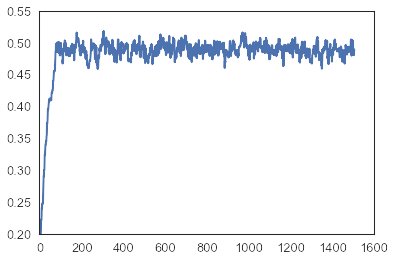

In [153]:
s = SineMH(x,y)
result = s.fit(1500)
plt.plot(result)

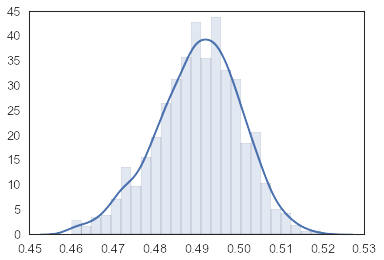

In [154]:
sns.distplot(result[200:])

**Conclusion**

In [117]:
norm.rvs(size=1,loc=0,scale=.001)

array([-0.00050538])